%matplotlib notebook
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt




In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import networkx as nx
import random
import scipy
import itertools
from operator import itemgetter

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})


In [2]:
def entropy4(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = np.e if base is None else base
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    

def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[..., -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

class BrainNet():
    def __init__(self, n_inputs, n_neurons, cap_size, n_rounds, sparsity, homeostasis, tau = .1, plasticity = 0):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.cap_size = cap_size
        self.tau = tau
        self.n_rounds = n_rounds
        self.sparsity = sparsity
        self.generate_graph()
        self.reset_weights()
        # self.plasticity_params = np.zeros((2, 6))
        self.plasticity = plasticity
        self.debug_rec_weights = np.ones((n_rounds, n_neurons, n_neurons))
        self.homeostasis = homeostasis

    def generate_graph(self):
        self.input_adj = rng.random((n_inputs, self.n_neurons)) < self.sparsity
        self.rec_adj = np.logical_and(rng.random((self.n_neurons, self.n_neurons)) < self.sparsity, 
                                      np.logical_not(np.eye(self.n_neurons, dtype=bool)))
        
    def reset_weights(self):
        self.rec_weights = np.ones((self.n_neurons, self.n_neurons))
        
    def forward(self, update=False):
        self.activations = np.zeros((self.n_rounds, self.n_neurons))


        self.activations[0, :self.cap_size] = 1

        for i in range(self.n_rounds-1):
            self.tau = self.tau/(1 + 5 *self.tau)
            self.activations[i+1] = k_cap(self.activations[i] @ (self.rec_adj * self.rec_weights), self.cap_size)
            if update: 
                self.update_weights(i)
        return self.activations
    
    def update_weights(self, step):
        self.debug_rec_weights[step] = self.rec_weights
        flattened_weights = self.rec_weights.flatten()/np.sum(self.rec_weights)
        entropy_grad = -1 * (entropy4(flattened_weights) + np.log(flattened_weights))/(1 - flattened_weights)
        entropy_grad = entropy_grad.reshape((n_neurons, n_neurons))
        entropy_grad = entropy_grad - np.min(entropy_grad)
        
        plasticity_rule = self.activations[step-1,:][:,np.newaxis] * self.activations[step, :][np.newaxis, :] * self.rec_adj - self.tau * entropy_grad
        # print("max p: {} min p: {} max e: {} min e: {}".format(np.max(plasticity_rule), np.min(plasticity_rule), np.max(entropy_grad), np.min(entropy_grad)))
        self.rec_weights += plasticity_rule * self.plasticity 
        if self.homeostasis:
            self.rec_weights = self.rec_weights / (self.rec_weights.sum(axis=1)[:, np.newaxis])

In [3]:
class STDP(BrainNet):
	def __init__(self, n_inputs, n_neurons, cap_size, n_rounds, sparsity, alpha_0, alpha_1, alpha_2, alpha_3, homeostasis=False, tau = .1, plasticity = 0, multiplier = 100):
		super().__init__(n_inputs, n_neurons, cap_size, n_rounds, sparsity, homeostasis, tau)
		self.alpha = np.asarray([alpha_0, alpha_1, alpha_2, alpha_3])
		self.multiplier = multiplier

	def trick_memory(self):
		
		self.activations = []
		for i in range(self.n_rounds):
			arr = np.asarray([1] * self.cap_size + [0] * (self.n_neurons-self.cap_size))
			np.random.shuffle(arr)
			self.activations.append(arr)

		self.activations = np.asarray(self.activations)
	
		for i in range(self.n_rounds):
			self.update_weights(i)
	
		#test
		self.test_activations = np.zeros((self.n_rounds, self.n_neurons))
		self.test_activations[0] = self.activations[0]
		for i in range(self.n_rounds-1):
			self.test_activations[i+1] = k_cap(self.test_activations[i] @ (self.rec_adj * self.rec_weights), self.cap_size)
		
		
		obj = np.sum(self.activations * self.test_activations, axis = 1)
		return obj

	def update_weights(self, step):
		if step - 1 >= 0:
			prior = self.activations[step-1,:][:,np.newaxis] * self.activations[step, :][np.newaxis, :] * self.rec_adj * self.alpha[0]
		else:
			prior = 0
		
		current = self.activations[step,:][:,np.newaxis] * self.activations[step, :][np.newaxis, :] * self.rec_adj * self.alpha[1]
		
		if step + 1 < self.n_rounds:
			forward = self.activations[step+1,:][:,np.newaxis] * self.activations[step, :][np.newaxis, :] * self.rec_adj * self.alpha[2]
		else:
			forward = 0

		if step + 1 < self.n_rounds and step - 1 >= 0:
			jump = self.activations[step+1,:][:,np.newaxis] * self.activations[step, :][np.newaxis, :] * self.rec_adj * self.alpha[3]
		else:
			jump = 0
		# print("max p: {} min p: {} max e: {} min e: {}".format(np.max(plasticity_rule), np.min(plasticity_rule), np.max(entropy_grad), np.min(entropy_grad)))
		self.rec_weights += (prior + current + forward + jump) * self.multiplier

		if self.homeostasis:
			self.rec_weights = self.rec_weights / (self.rec_weights.sum(axis=1)[:, np.newaxis])

In [4]:
def min_degree(adj_matrix, k = 10):
	graph = nx.from_numpy_matrix(adj_matrix)
	nodes_degrees_pair = graph.degree()

	while len(graph.nodes) > k:
		nodes, degrees = list(zip(*graph.degree()))
		min_degree = min(degrees)
		idx = degrees.index(min_degree)
		graph.remove_node(nodes[idx])

	return graph.number_of_edges()

def greedy(adj_matrix, k = 10):
	graph = nx.from_numpy_matrix(adj_matrix)

	nodes = [random.randint(0, graph.number_of_nodes() - 1)]

	while len(nodes) < k - 1:
		all_neighbors = []
		for node in nodes:
			all_neighbors.extend(graph.neighbors(node))
		all_neighbors = [i for i in all_neighbors if i not in nodes]
		nodes.append(max(set(all_neighbors), key=all_neighbors.count))
	return graph.subgraph(nodes).number_of_edges()

def extended_greedy(adj_matrix, k = 10):
	graph = nx.from_numpy_matrix(adj_matrix)

	nodes = [random.randint(0, graph.number_of_nodes() - 1)]

	while len(nodes) < k - 1:
		all_neighbors = []
		for node in nodes:
			all_neighbors.extend(graph.neighbors(node))
		all_neighbors = [i for i in all_neighbors if i not in nodes]
		nodes.append(max(set(all_neighbors), key=all_neighbors.count))
	
	for t in range(len(graph.nodes())):
		best_node = max(graph.degree(graph.nodes() - nodes), key=itemgetter(1))[0]
		subgraph = graph.subgraph(nodes)
		worst_node = min(subgraph.degree(subgraph.nodes()), key=itemgetter(1))[0]
		nodes.remove(worst_node)
		nodes.append(best_node)
	return graph.subgraph(nodes).number_of_edges()

n_inputs = 500
n_neurons = 1000
cap_size = 30
n_rounds = 100
sparsity = 0.05
net = STDP(n_inputs, n_neurons, cap_size, n_rounds, sparsity, alpha_0=.2, alpha_1=.2, alpha_2=.2, alpha_3 = .1, homeostasis=False)
net.trick_memory()
print(greedy)


<function greedy at 0x7f9735ceb560>


In [ ]:
n_inputs = 500
n_neurons = 1000
cap_size = 30
n_rounds = 10
sparsity = 0.05

net = BrainNet(n_inputs, n_neurons, cap_size, n_rounds, sparsity, homeostasis=False)
inputs = np.zeros((1, n_inputs))
inputs[0, :cap_size] = 1
net.plasticity_params = np.array([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]]) * 5e-2

NameError: name 'curve_values' is not defined

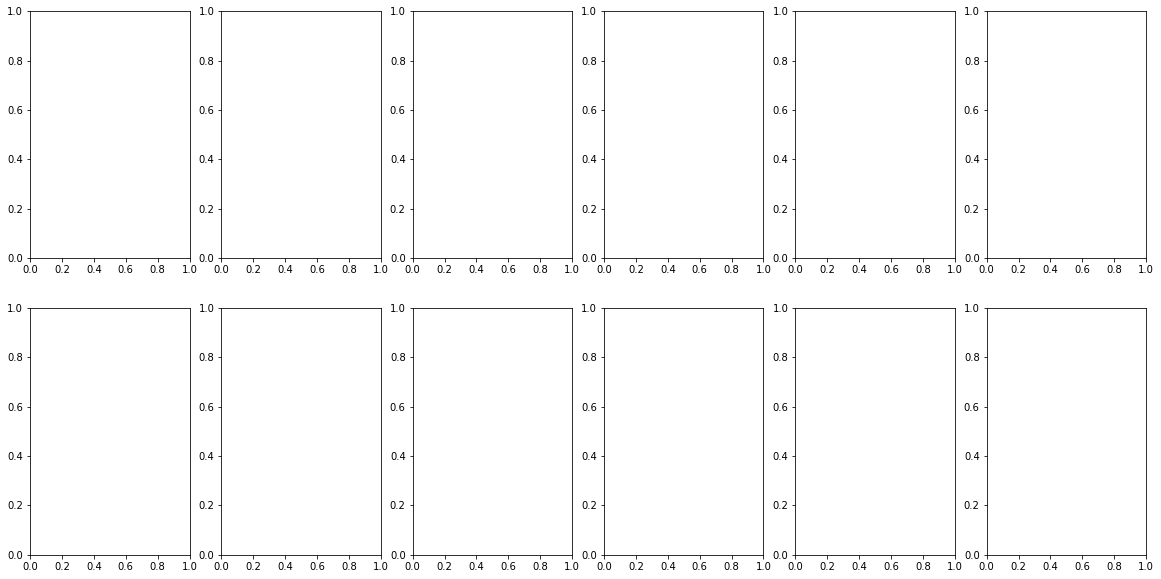

In [ ]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(2, 6)
figure.set_size_inches(20, 10)
for parameter_zero_idx in range(2):
    for parameter_one_idx in range(6):
        vals, densities = list(zip(*curve_values[parameter_zero_idx][parameter_one_idx]))
        axis[parameter_zero_idx, parameter_one_idx].scatter(vals, densities)
        axis[parameter_zero_idx, parameter_one_idx].set_title("Param {} by {}".format(parameter_zero_idx, parameter_one_idx))

plt.savefig("banana.png")

In [ ]:

inputs = np.zeros((1, n_inputs))
inputs[0, :cap_size] = 1
net.plasticity_params = np.array([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]]) * 5e-2

In [ ]:
from tqdm import tqdm
num_samples = 10
all_values = []
for val in tqdm(np.linspace(0, 5, 100)):
    final_list = []
    for _ in range(num_samples):
        
        net, inputs = initialize_net()
        
        final_list.append(obj[-1])
    all_values.append((val, np.mean(final_list)))
        

  1%|██▎                                                                                                                                                                                                                                | 1/100 [1:27:34<144:30:28, 5254.83s/it]

In [ ]:
net.plasticity_params

array([[ 0.032, -0.001,  0.017, -0.006, -0.005,  0.026],
       [ 0.02 , -0.014,  0.011, -0.011, -0.006,  0.012]])

In [143]:
net.plasticity_params

array([[ 0.017,  0.009,  0.003,  0.019, -0.009, -0.005],
       [ 0.02 ,  0.003, -0.01 ,  0.015, -0.001, -0.006]])

<IPython.core.display.Javascript object>


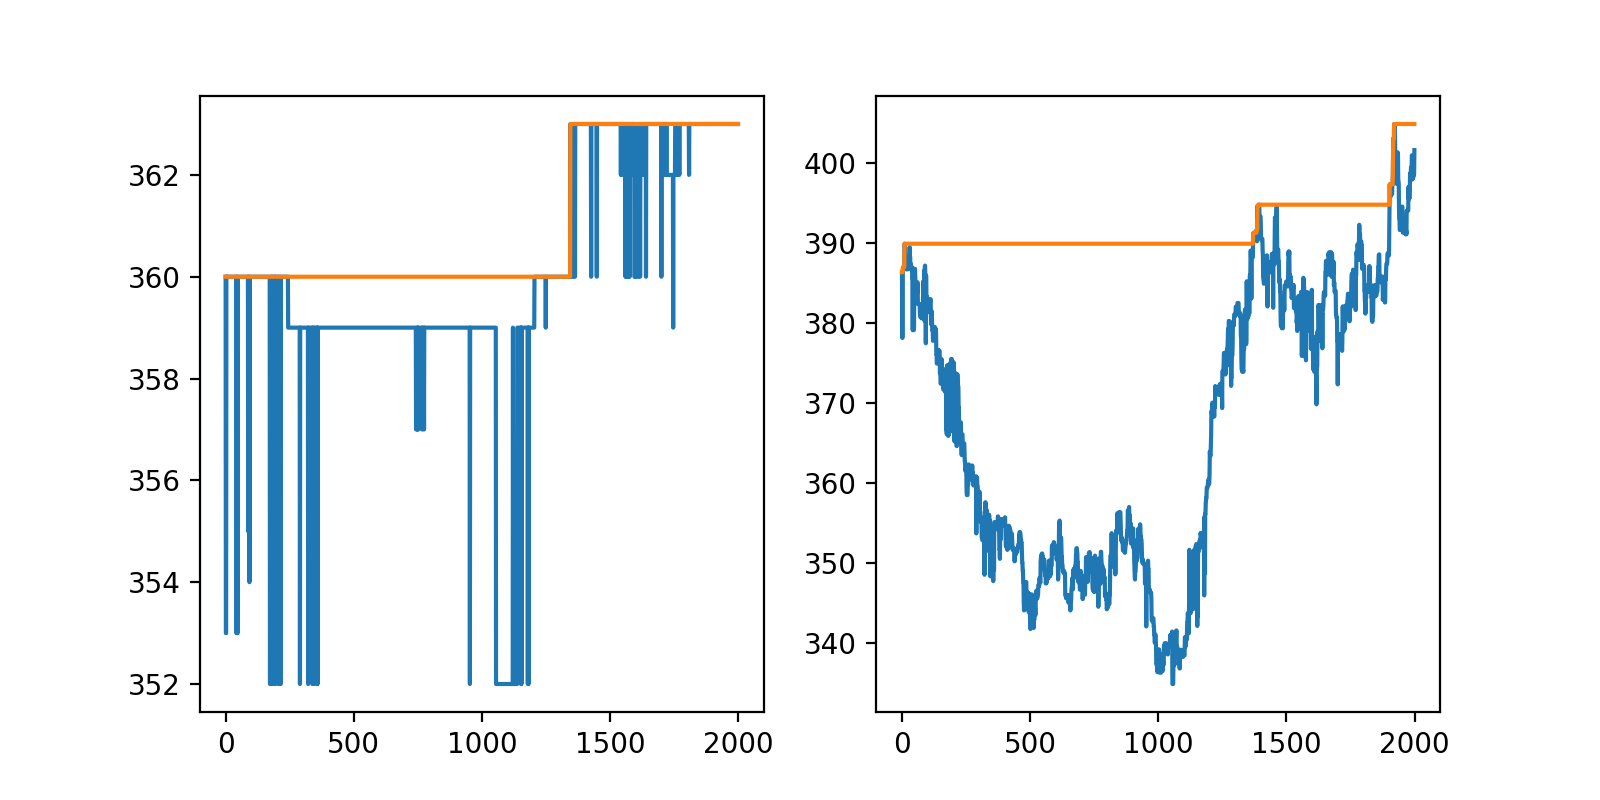

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(obj)
axes[0].plot(obj_r)
axes[1].plot(w_obj)
axes[1].plot(np.maximum.accumulate(w_obj))

363.0
401.60106981299117


<IPython.core.display.Javascript object>


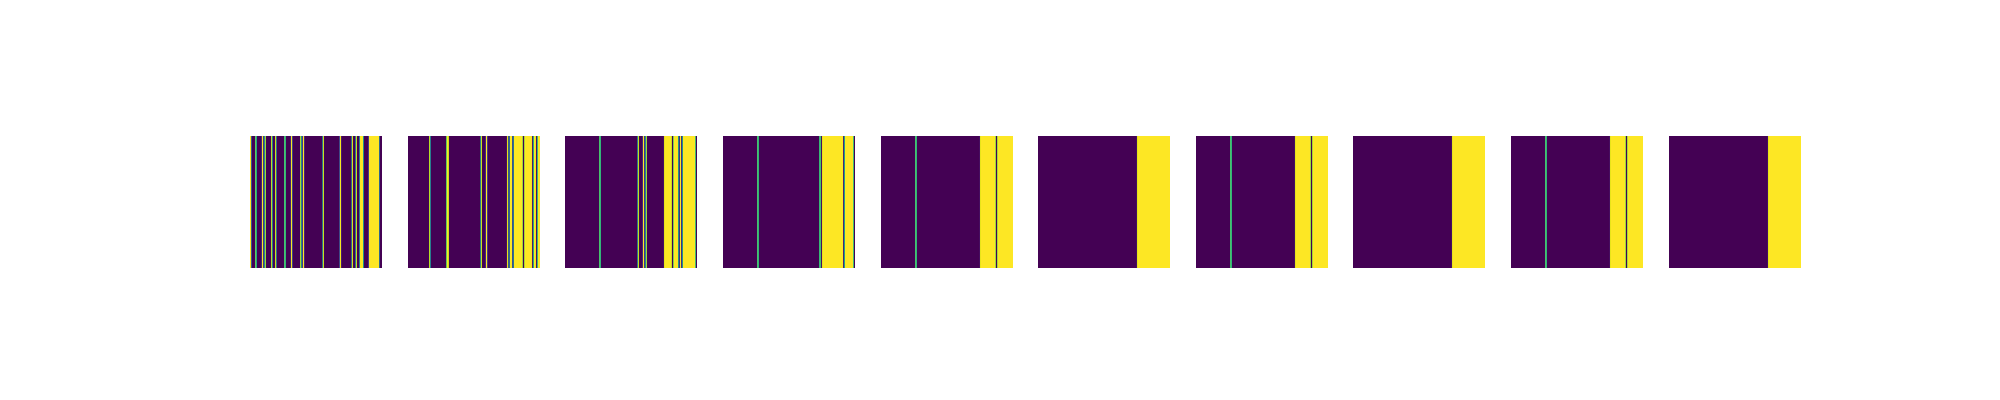

In [149]:
net.reset_weights()
outputs = net.forward(inputs, update=True)
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean())
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * (net.rec_adj * net.rec_weights)[np.newaxis, :, :]).sum(axis=(1,2)).mean())
idx = outputs[0, -1].argsort(axis=-1)

fig, axes = plt.subplots(1, n_rounds, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(outputs[:, i][:, idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()

349.0
388.59277083354607


<IPython.core.display.Javascript object>


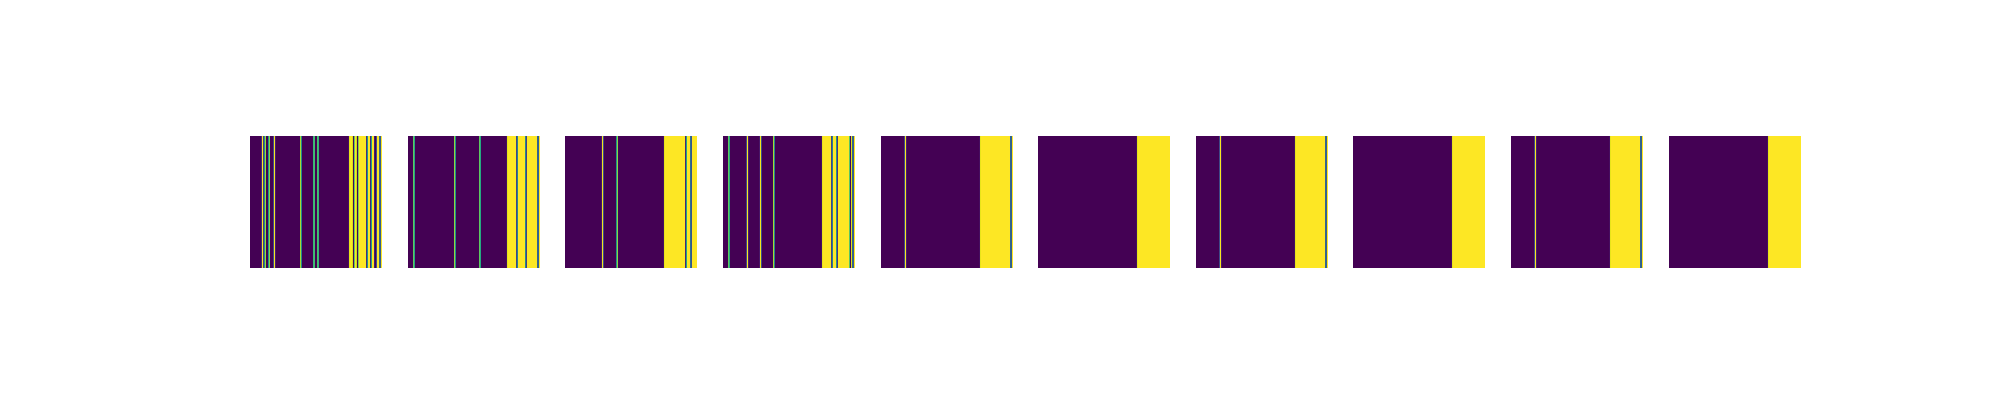

In [158]:
net.reset_weights()
net.generate_graph()
outputs = net.forward(inputs, update=True)
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean())
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * (net.rec_adj * net.rec_weights)[np.newaxis, :, :]).sum(axis=(1,2)).mean())
idx = outputs[0, -1].argsort(axis=-1)

fig, axes = plt.subplots(1, n_rounds, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(outputs[:, i][:, idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()

In [15]:

import time
from tqdm import tqdm
rounds_to_all = {}
n_rounds = 100
all_values = []

params = np.linspace(0, 5, num=15)

taus = [0]
for tau in taus:
    for val in tqdm(params):
        t1 = time.time()
        n_iter = 2
        n_nets = 40
        step_size = 1e-3
        obj = np.zeros((n_rounds, n_iter, n_nets))
        greedy_results = np.zeros((n_nets))
        min_degree_results = np.zeros((n_nets))
        extended_greedy_results = np.zeros((n_nets))
        comps_before_after = np.zeros((n_rounds, n_iter, n_nets))
        comps_before_after_two = np.zeros((n_rounds, n_iter, n_nets))
        periodics = np.zeros((n_rounds, n_iter, n_nets))
        overlap_penalty = 5e-1
        done_before = False
        nets = [BrainNet(n_inputs, n_neurons, cap_size, n_rounds, sparsity, homeostasis=False, tau=tau, plasticity=val) for i in range(n_nets)]
        for i, net in enumerate(nets):
            net.reset_weights()
            all_outputs = net.forward(update=True)
            
            for round_idx in range(n_rounds):
                outputs = all_outputs[round_idx]
                obj[round_idx, 0, i] = (outputs[ :, np.newaxis] * outputs[ np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean()

        old_params = np.zeros((2, 6))
        
        for i in range(1, n_iter):
            for j, net in enumerate(nets):
                net.reset_weights()

                all_outputs = net.forward(update=True)
                all_activations = np.zeros((n_neurons))

                for round_idx in range(1, n_rounds):
                    outputs = all_outputs[round_idx]
                    all_activations += outputs
                    comps_before_after_two[round_idx, i, j] = (all_outputs[round_idx] * all_outputs[round_idx-2]).sum()
                    comps_before_after[round_idx, i, j] = (all_outputs[round_idx] * all_outputs[round_idx-1]).sum()
                    if comps_before_after[round_idx, i, j] + 15 < comps_before_after_two[round_idx, i, j]:
                        periodics[round_idx, i, j] = 1
                    else:
                        periodics[round_idx, i, j] = 0
                    # print((all_outputs[round_idx] * all_outputs[round_idx-1]).sum())
                    # print("{} {} {}".format(round_idx > 80, (all_outputs[round_idx] * all_outputs[round_idx-1]).sum() < 2, not done_before))                
                    obj[round_idx, i, j] = (outputs[ :, np.newaxis] * outputs[ np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean()
                
        for j, net in enumerate(nets):
            greedy_results[j] = greedy(net.rec_adj, k=cap_size)
            min_degree_results[j] = min_degree(net.rec_adj, k=cap_size)
            extended_greedy_results[j] = extended_greedy(net.rec_adj, k=cap_size)
        for round_idx in range(n_rounds):
            if round_idx in rounds_to_all:
                rounds_to_all[round_idx].append((tau, val, obj[round_idx, -1, :].mean(), comps_before_after[round_idx, -1, :].mean(), periodics[round_idx, -1, :].mean(), greedy_results.mean(), min_degree_results.mean()))
            else:
                rounds_to_all[round_idx] = [(tau, val, obj[round_idx, -1, :].mean(), comps_before_after[round_idx, -1, :].mean(), periodics[round_idx, -1, :].mean(), greedy_results.mean(), min_degree_results.mean())]
import pickle
with open("/nethome/eguha3/SantoshHebbian/cristos_again3.pkl", "wb") as f:
    pickle.dump(rounds_to_all, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [2:58:13<00:00, 712.90s/it]


In [5]:

import time
from tqdm import tqdm
rounds_to_all = {}
n_rounds = 10
taus = [0]
all_values = []
params = [[1]] + [np.linspace(-.05, .05 ,3, endpoint=True)] * 3
params = list(itertools.product(*params))
for tau in taus:
    for val in tqdm(params):
        t1 = time.time()
        n_iter = 2
        n_nets = 15
        step_size = 1e-3
        obj = np.zeros((n_rounds, n_iter, n_nets))
        greedy_results = np.zeros((n_nets))
        min_degree_results = np.zeros((n_nets))
        comps_before_after = np.zeros((n_rounds, n_iter, n_nets))

    
        overlap_penalty = 5e-1
        done_before = False
        nets = [STDP(n_inputs, n_neurons, cap_size, n_rounds, sparsity, alpha_0=val[0], alpha_1=val[1], alpha_2=val[2], alpha_3=val[3], homeostasis=False) for i in range(n_nets)]
        for i in range(1, n_iter):
            for j, net in enumerate(nets):
                net.reset_weights()

                all_outputs = net.trick_memory()

                all_activations = np.zeros((n_neurons))
                for round_idx in range(0, n_rounds):
                    outputs = all_outputs[round_idx]
                    
                    all_activations += outputs
                    comps_before_after[round_idx, i, j] = (all_outputs[round_idx] * all_outputs[round_idx-2]).sum()
                
                    obj[round_idx, i, j] = outputs
                    
            for j, net in enumerate(nets):
                greedy_results[j] = greedy(net.rec_adj, k=cap_size)
                min_degree_results[j] = min_degree(net.rec_adj, k=cap_size)
            
            
            for round_idx in range(n_rounds):
                if round_idx in rounds_to_all:\
                    rounds_to_all[round_idx].append((tau, val, obj[round_idx, -1, :].mean(), comps_before_after[round_idx, -1, :].mean(), greedy_results.mean(), min_degree_results.mean()))
                else:
                    rounds_to_all[round_idx] = [(tau, val, obj[round_idx, -1, :].mean(), comps_before_after[round_idx, -1, :].mean(), greedy_results.mean(), min_degree_results.mean())]
            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [09:15<00:00, 20.56s/it]


In [16]:
import pickle
with open("/nethome/eguha3/SantoshHebbian/cristos_only_15.pkl", "wb") as f:
	pickle.dump(rounds_to_all, f)
print(rounds_to_all[0])

[(0, 0.0, 0.0, 0.0, 0.0, 136.85, 143.425), (0, 0.35714285714285715, 0.0, 0.0, 0.0, 135.85, 143.75), (0, 0.7142857142857143, 0.0, 0.0, 0.0, 136.7, 143.025), (0, 1.0714285714285714, 0.0, 0.0, 0.0, 136.325, 142.65), (0, 1.4285714285714286, 0.0, 0.0, 0.0, 136.05, 143.25), (0, 1.7857142857142858, 0.0, 0.0, 0.0, 136.475, 143.025), (0, 2.142857142857143, 0.0, 0.0, 0.0, 136.175, 142.8), (0, 2.5, 0.0, 0.0, 0.0, 137.325, 142.75), (0, 2.857142857142857, 0.0, 0.0, 0.0, 137.45, 143.35), (0, 3.2142857142857144, 0.0, 0.0, 0.0, 135.725, 143.1), (0, 3.5714285714285716, 0.0, 0.0, 0.0, 136.7, 142.65), (0, 3.928571428571429, 0.0, 0.0, 0.0, 137.475, 142.0), (0, 4.285714285714286, 0.0, 0.0, 0.0, 136.45, 142.2), (0, 4.642857142857143, 0.0, 0.0, 0.0, 137.475, 143.125), (0, 5.0, 0.0, 0.0, 0.0, 138.075, 143.525)]


In [16]:
new_dict = {}
import pickle
plot_tau = False
if not plot_tau:
    for key in rounds_to_all.keys():
        all_values = rounds_to_all[key]
        taus, vals, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
        
        for i in range(len(vals)):
            if vals[i] not in new_dict:
                new_dict[vals[i]] = [(key, taus[i], densities[i], comps[i], greedy_results[i], min_degree_results[i])]
            else:
                new_dict[vals[i]].append((key, taus[i], densities[i], comps[i], greedy_results[i], min_degree_results[i]))
else:
    for key in rounds_to_all.keys():
        all_values = rounds_to_all[key]
        taus, vals, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
        for i in range(len(vals)):
            if taus[i] not in new_dict:
                new_dict[taus[i]] = [(key, vals[i], densities[i], comps[i], greedy_results[i], min_degree_results[i])]
            else:
                new_dict[taus[i]].append((key, vals[i], densities[i], comps[i], greedy_results[i], min_degree_results[i]))
import matplotlib.pyplot as plt 
import math
counter = 0
already_plotted_greedy = False
new_array = []
for key in new_dict.keys():
    all_values = new_dict[key]
    vals, other_measures, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
    densities = np.asarray(densities)
    greedies = np.asarray(greedy_results)
    min_degrees = np.asarray(min_degree_results)
    comps = np.asarray(comps)

    idx_of_max = np.argmax(densities)

    new_array.append((key, densities[idx_of_max]))
    plot_comps = True
    if not plot_comps:
        
        plt.plot(vals, densities, label=math.ceil(key * 100)/100)
        if not already_plotted_greedy:
            already_plotted_greedy = True
            ax = plt.axes()
            ax.set(facecolor = "white")
            plt.plot(vals, greedies, label="greedy")
            plt.plot(vals, min_degrees, label="min_degree")
    else:
        print(comps)
        ax = plt.axes()
        ax.set(facecolor = "white")
        print(key)
        plt.plot(vals, comps, label=math.ceil(key * 100)/100)



# params, dens = list(zip(*new_array))
# plt.plot(params,dens)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Densities")
plt.legend()
plt.savefig("/nethome/eguha3/SantoshHebbian/tripartite.png")  
plt.clf()


[0.   1.05 0.75 0.75 1.   1.55 1.45 0.95 1.35 1.   1.3  1.45 1.   1.3
 1.3  1.6  1.2  1.45 1.3  1.7  1.25 1.15 0.9  0.7  0.9  1.35 1.25 1.4
 1.3  1.7  1.   1.05 1.3  1.35 1.4  0.95 1.   1.4  1.2  0.95 1.1  1.6
 1.5  1.05 1.1  0.85 1.35 1.1  1.05 1.4  1.25 1.1  1.15 1.3  1.   1.05
 1.05 1.25 1.35 1.15 1.5  0.8  0.85 0.85 0.95 1.45 1.1  1.1  1.45 1.45
 1.2  1.2  1.2  1.25 0.9  1.3  1.15 0.95 1.2  1.45 1.1  1.25 1.55 1.55
 1.7  1.45 1.2  1.2  1.   1.5  1.45 1.1  1.1  1.   0.95 1.1  1.6  1.35
 1.4  1.  ]
0
[0.   1.85 1.75 0.6  1.35 1.9  2.4  1.95 1.4  2.05 1.75 1.95 2.8  2.85
 3.65 3.35 2.7  2.35 2.4  2.8  3.05 2.55 3.15 2.1  2.05 2.15 2.6  2.65
 1.95 1.95 2.1  2.3  2.3  2.25 1.95 2.5  2.4  2.15 2.65 2.05 1.85 1.7
 1.95 1.85 2.5  2.6  3.   2.55 2.55 2.65 2.25 2.3  2.7  2.45 2.4  2.7
 2.35 2.6  2.45 2.65 2.7  2.6  2.5  3.   2.85 2.7  2.65 2.65 2.95 2.95
 2.7  2.15 2.55 2.55 2.8  3.05 2.2  2.25 2.7  2.4  2.6  2.95 2.8  2.8
 2.7  2.5  3.2  3.25 3.45 2.65 2.85 2.7  2.45 3.   2.65 2.45 3.1  3.1

/localscratch/eguha3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/localscratch/eguha3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/localscratch/eguha3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous ax

<Figure size 432x288 with 0 Axes>

In [4]:
#STDP ONLY!!!!!!!!
new_dict = {}
import pickle
with open("/nethome/eguha3/SantoshHebbian/stdp_small_four_fixed_long.pkl", "rb") as f:
    rounds_to_all = pickle.load(f)
plot_tau = False
if not plot_tau:
    for key in rounds_to_all.keys():
        all_values = rounds_to_all[key]
        taus, vals, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
        
        for i in range(len(vals)):
            if vals[i] not in new_dict:
                new_dict[vals[i]] = [(key, taus[i], densities[i], comps[i], greedy_results[i], min_degree_results[i])]
            else:
                new_dict[vals[i]].append((key, taus[i], densities[i], comps[i], greedy_results[i], min_degree_results[i]))
else:
    for key in rounds_to_all.keys():
        all_values = rounds_to_all[key]
        taus, vals, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
        for i in range(len(vals)):
            if taus[i] not in new_dict:
                new_dict[taus[i]] = [(key, vals[i], densities[i], comps[i], greedy_results[i], min_degree_results[i])]
            else:
                new_dict[taus[i]].append((key, vals[i], densities[i], comps[i], greedy_results[i], min_degree_results[i]))
import matplotlib.pyplot as plt 
import math
counter = 0
already_plotted_greedy = True
new_array = []
keys_to_densities = []
for key in new_dict.keys():
    all_values = new_dict[key]
    vals, other_measures, densities, comps, greedy_results, min_degree_results = list(zip(*all_values))
    densities = np.asarray(densities)
    greedies = np.asarray(greedy_results)
    min_degrees = np.asarray(min_degree_results)
    comps = np.asarray(comps)

    idx_of_max = np.argmax(densities)
    new_array.append((key, densities[idx_of_max]))
    plot_comps = False

    if not plot_comps:
        keys_to_densities.append((densities[-1], key))
        plt.plot(vals, densities, label=key)
        if not already_plotted_greedy:
            already_plotted_greedy = True
            ax = plt.axes()
            ax.set(facecolor = "white")
            plt.plot(vals, greedies, label="greedy")
            plt.plot(vals, min_degrees, label="min_degree")
    else:
        ax = plt.axes()
        ax.set(facecolor = "white")
        plt.plot(vals, comps, label=key)



# params, dens = list(zip(*new_array))
# plt.plot(params,dens)
# plt.legend()

keys_to_densities.sort(key=lambda x: x[0])
print(keys_to_densities[-5:])
plt.xlabel("Rounds")
plt.ylabel("Densities")
plt.legend()
plt.savefig("/nethome/eguha3/SantoshHebbian/STDP_densities_four_fixed_long.png")  
plt.clf()

[(9.0, (1, 0.0, -0.05, 0.0)), (9.6, (1, -0.05, -0.05, 0.0)), (9.6, (1, 0.0, -0.05, -0.05)), (9.933333333333334, (1, -0.05, -0.05, -0.05)), (10.066666666666666, (1, 0.05, -0.05, -0.05))]


<Figure size 432x288 with 0 Axes>

In [10]:
print(best_key)

(1, 0.05, -0.05, -0.05)


In [10]:
import pickle
with open("rounds_to_all.pkl", "wb") as f:
	pickle.dump(rounds_to_all, f)

In [17]:
net.plasticity_params

array([[0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [13]:
net.plasticity_params

array([[ 0.02 , -0.004,  0.015,  0.007,  0.019,  0.007,  0.001, -0.002],
       [ 0.055, -0.012,  0.015,  0.022,  0.012,  0.016,  0.039, -0.025]])

In [29]:
net.plasticity_params

array([[ 0.01 ,  0.002,  0.002, -0.009,  0.007,  0.003,  0.007,  0.003],
       [ 0.015,  0.013,  0.001,  0.005, -0.013, -0.01 ,  0.004, -0.005]])

<IPython.core.display.Javascript object>


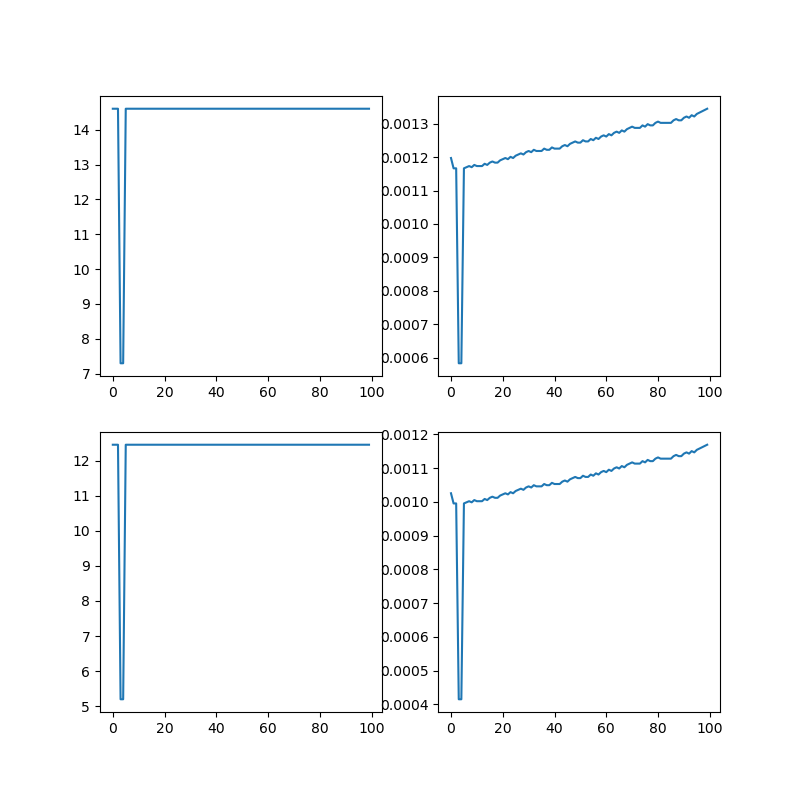

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].plot(obj.mean(axis=-1))
axes[0, 1].plot(w_obj.mean(axis=-1))
axes[1, 0].plot(obj_p.mean(axis=-1))
axes[1, 1].plot(w_obj_p.mean(axis=-1))

1235.0
1258.9139868920101


<IPython.core.display.Javascript object>


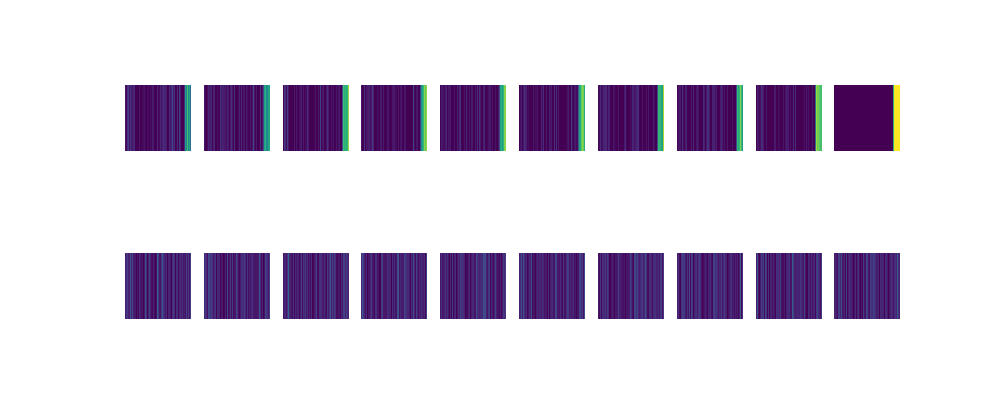

In [23]:
net.reset_weights()
outputs = net.forward(inputs, update=True)
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean())
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * (net.rec_adj * net.rec_weights)[np.newaxis, :, :]).sum(axis=(1,2)).mean())
idx = outputs[0, -1].argsort(axis=-1)

fig, axes = plt.subplots(2, n_rounds, figsize=(10, 4))
for i, ax in enumerate(axes[0]):
    ax.imshow(outputs[0, i][idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()
for i, ax in enumerate(axes[1]):
    ax.imshow(outputs[1, i][idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()

337.0
353.92621868099906


<IPython.core.display.Javascript object>


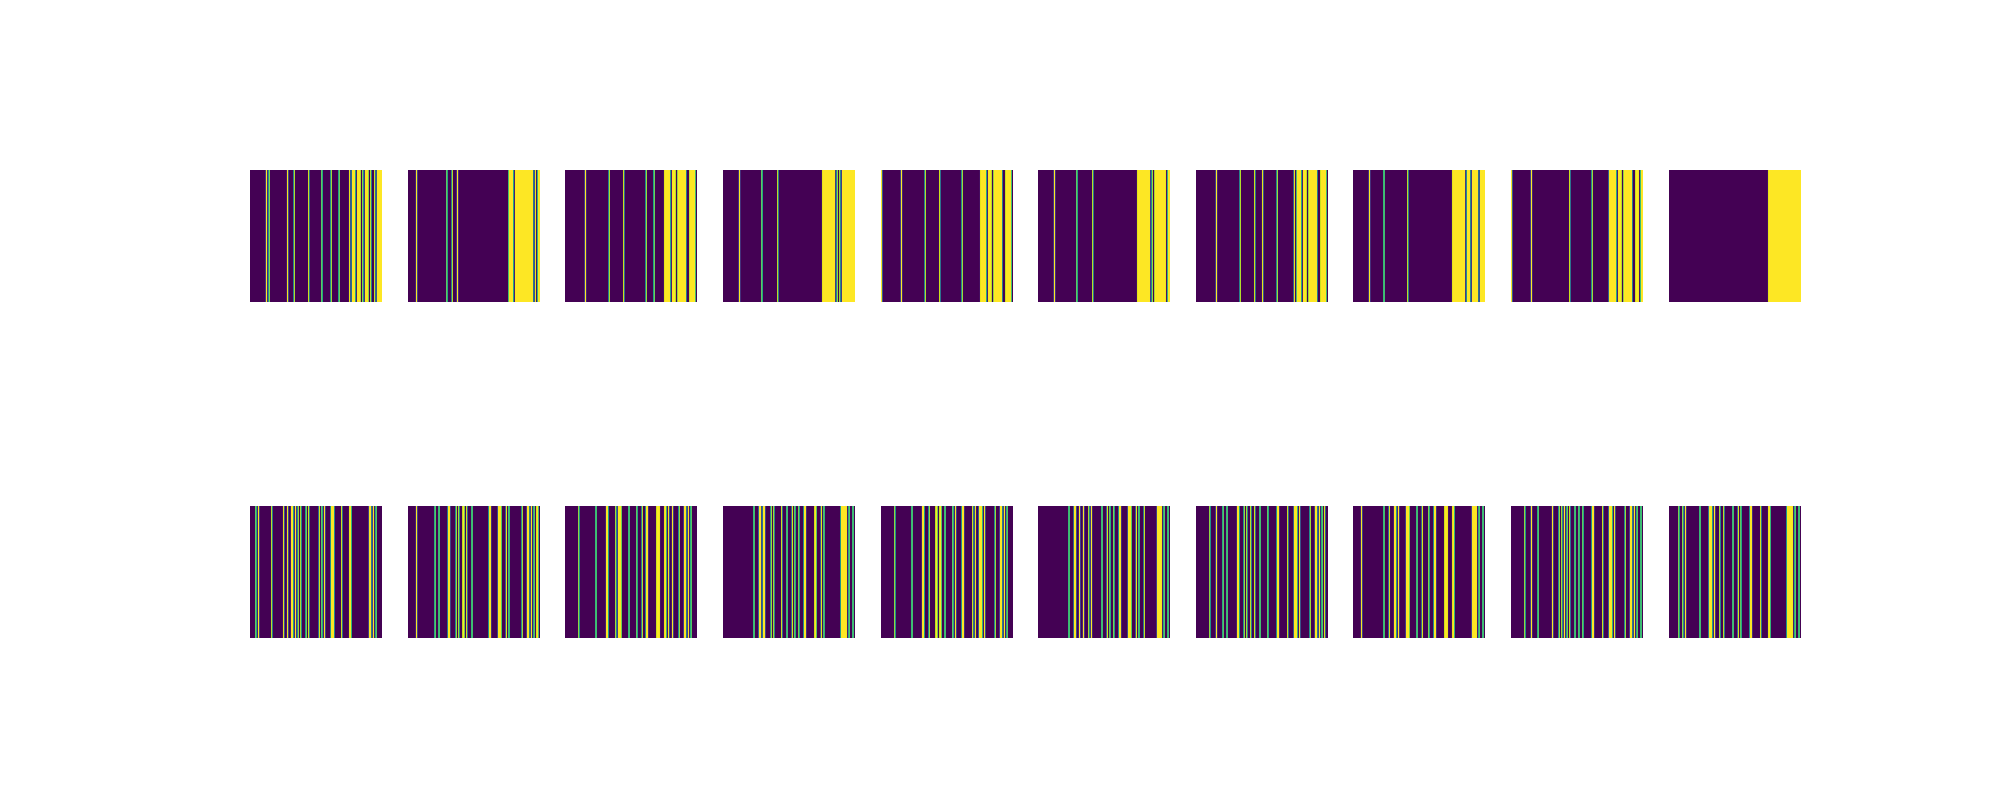

In [241]:
net.reset_weights()
net.generate_graph()
outputs = net.forward(inputs, update=True)
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * net.rec_adj[np.newaxis, :, :]).sum(axis=(1,2)).mean())
print((outputs[:, -1][:, :, np.newaxis] * outputs[:, -1][:, np.newaxis, :] * (net.rec_adj * net.rec_weights)[np.newaxis, :, :]).sum(axis=(1,2)).mean())
idx = outputs[0, -1].argsort(axis=-1)

fig, axes = plt.subplots(2, n_rounds, figsize=(10, 4))
for i, ax in enumerate(axes[0]):
    ax.imshow(outputs[0, i][idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()
for i, ax in enumerate(axes[1]):
    ax.imshow(outputs[1, i][idx] * np.ones((n_neurons, 1)))
    ax.set_axis_off()